## Import

In [16]:
import pandas as pd
import numpy as np
from math import log, exp, sqrt
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import kernel_ridge

## Read Data

In [2]:
X_data = pd.read_csv('./data/X_data.csv')
X_data = np.array(X_data.values.tolist())
X_data = X_data[:,3]
X_data = X_data.reshape((12,7,720))

Y_data = pd.read_csv('./data/Y_data.csv')
Y_data = np.array(Y_data.values.tolist())
Y_data = Y_data[:,1]
Y_data = Y_data.reshape((12,7,720))

blocks_name = pd.read_csv('./data/Blockface.csv')
blocks_name = blocks_name['UNITDESC'].values.tolist()

In [3]:
def pearson_corr(x, y):
    """
    Calculate the correlation of the vectors x and y
    """
    n = min(len(x),len(y))
    if n==0:
        return 0.0,n
    else:
        x = x[0:n]
        y = y[0:n]
        x_bar = np.mean(x)
        y_bar = np.mean(y)
        cov = np.sum(np.multiply((x-x_bar),(y-y_bar)))
        var_x = np.sum(np.square(x-x_bar))
        var_y = np.sum(np.square(y-y_bar))
        if var_x<=0 or var_y<=0:
            return 0.0, n
        else:
            r = min(cov/(sqrt(var_x)*sqrt(var_y)),1)
            return r, n

In [4]:
num_block = len(X_data)
cor_mat = np.zeros((num_block, num_block))
for i, b1 in enumerate(X_data):
    for j, b2 in enumerate(X_data):
        r, n = pearson_corr(b1, b2)
        cor_mat[i,j] = r

In [7]:
cor_df = pd.DataFrame(cor_mat,columns=blocks_name, index=blocks_name)

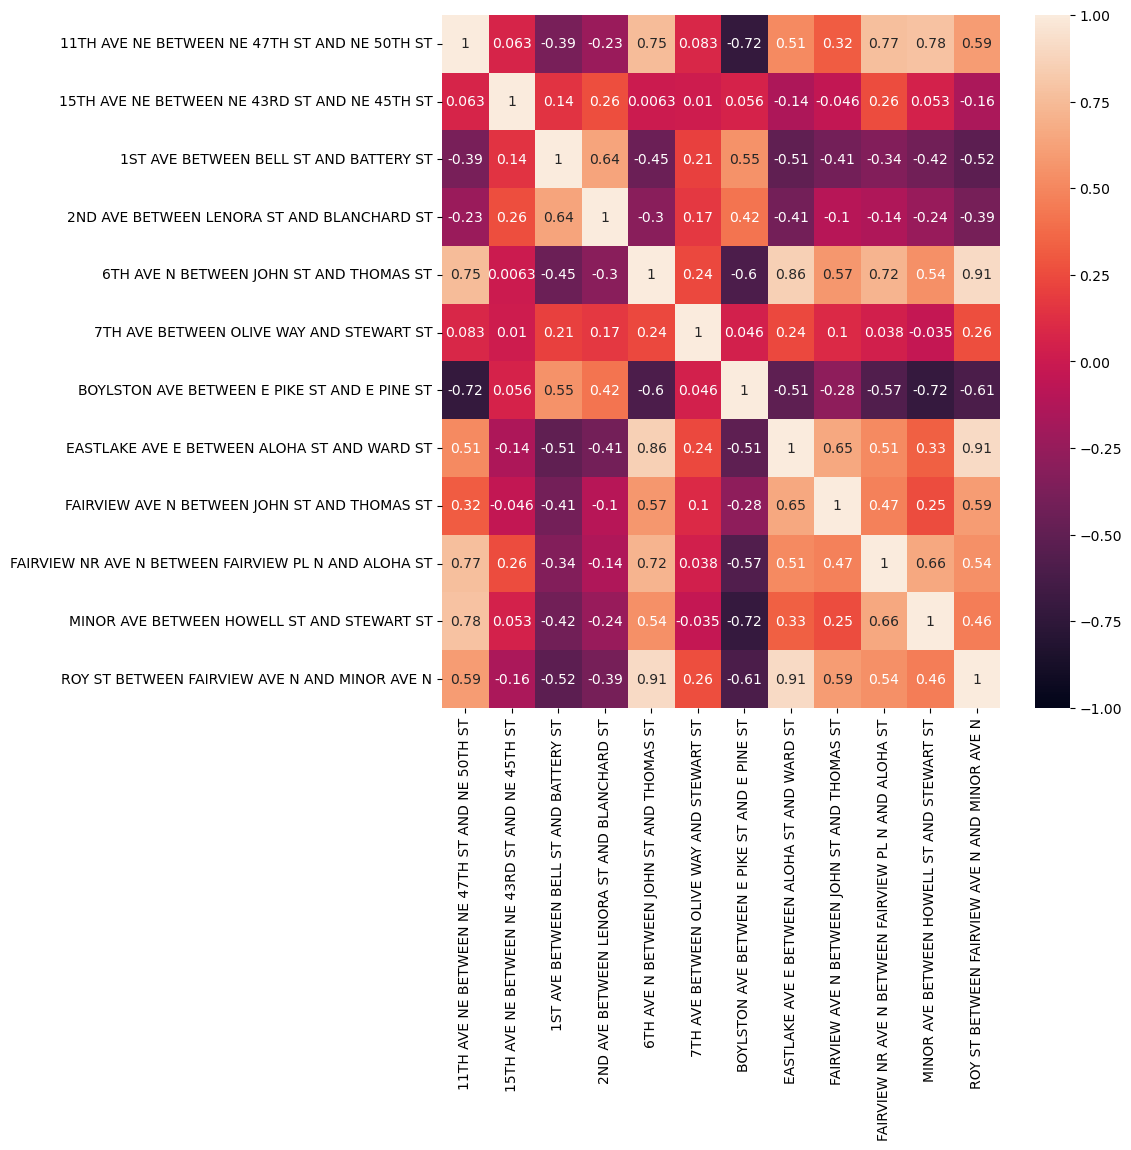

In [12]:
plt.figure(figsize=(9,9))
sn.heatmap(cor_df, annot=True, vmin=-1)
plt.show()

In [17]:
lambda_val = 0.3
gamma = 0.001

def corr_blocks(Ax, Ay, Bx, By):
    time = np.arange(720)
    rrg = kernel_ridge.KernelRidge(alpha=lambda_val, kernel='rbf', gamma=gamma)
    rrg.fit(Ax, Ay)
    
    prediction = rrg.predict(Bx)
    n = len(prediction)
    corr_error = 0
    error = 0
    
    for i in range(n):
        corr_error += np.mean(np.abs(By[i]-prediction[i]))
    
    #print("Correlation test MAE")
    #print(corr_error/n)
    
    for i in range(n):
        x_test = Bx[i]
        y_test = By[i]
        x_train = np.vstack((Ax, np.delete(Bx, i, axis=0)))
        y_train = np.vstack((Ay, np.delete(By, i, axis=0)))
        rrg.fit(x_train, y_train)
        prediction = rrg.predict(x_test.reshape(1,-1))
        error += np.mean(np.abs(y_test-prediction))
        
    #print("Combined MAE")
    #print(error/n)
    
    return corr_error/n, error/n

In [40]:
error_diff = np.empty((12,12))
for i in range(12):
    for j in range(12):
        corr_error, error = corr_blocks(X_data[i], Y_data[i], X_data[j], Y_data[j])
        error_diff[i][j] = error - corr_error
error_diff = error_diff.round(3)

In [41]:
df = pd.DataFrame(error_diff,columns=blocks_name, index=blocks_name)

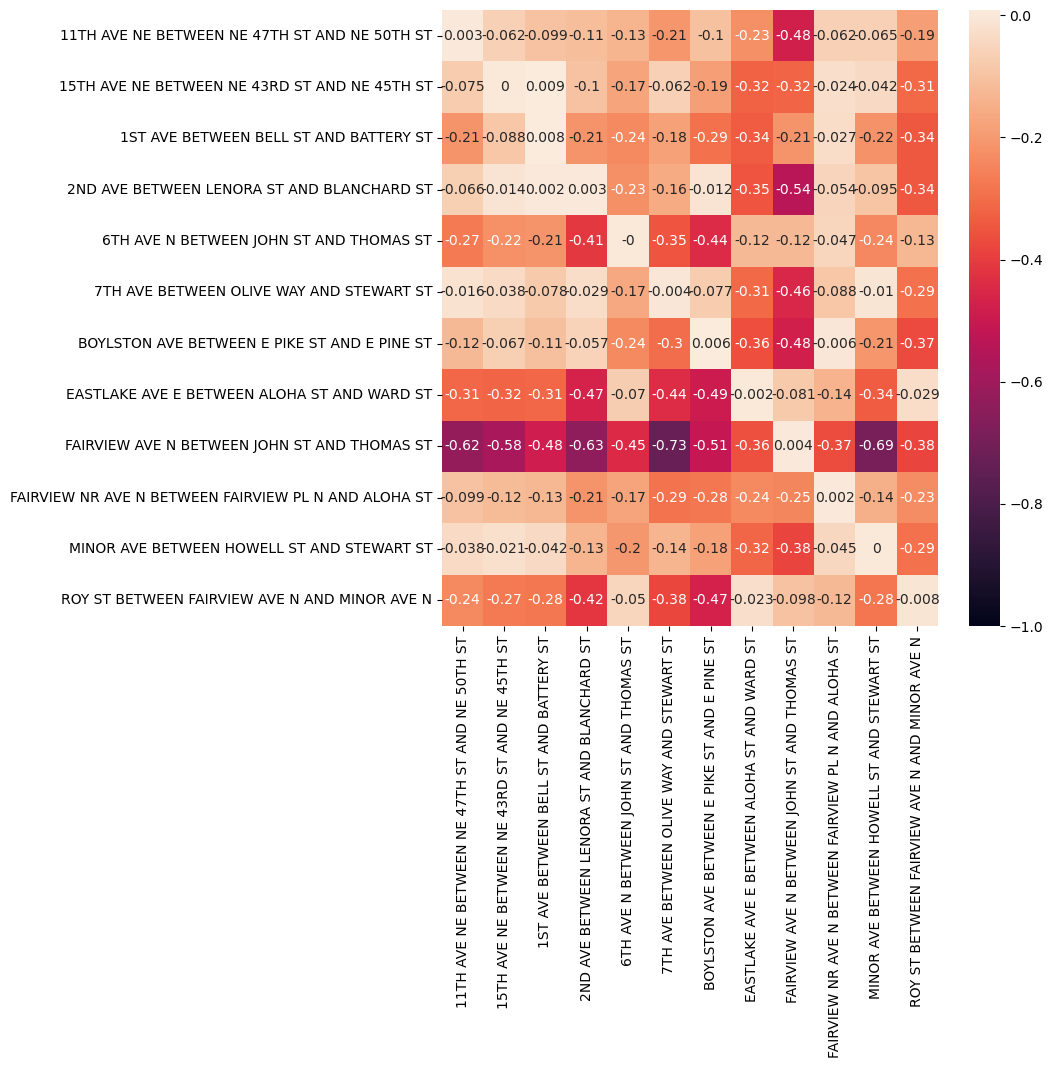

In [42]:
plt.figure(figsize=(8,8))
sn.heatmap(df, annot=True, vmin=-1)
plt.show()

In [29]:
corr_map = np.array(cor_mat)
error_diff = np.array(error_diff)
x = corr_map.flatten()
y = error_diff.flatten()
print(len(x))

144


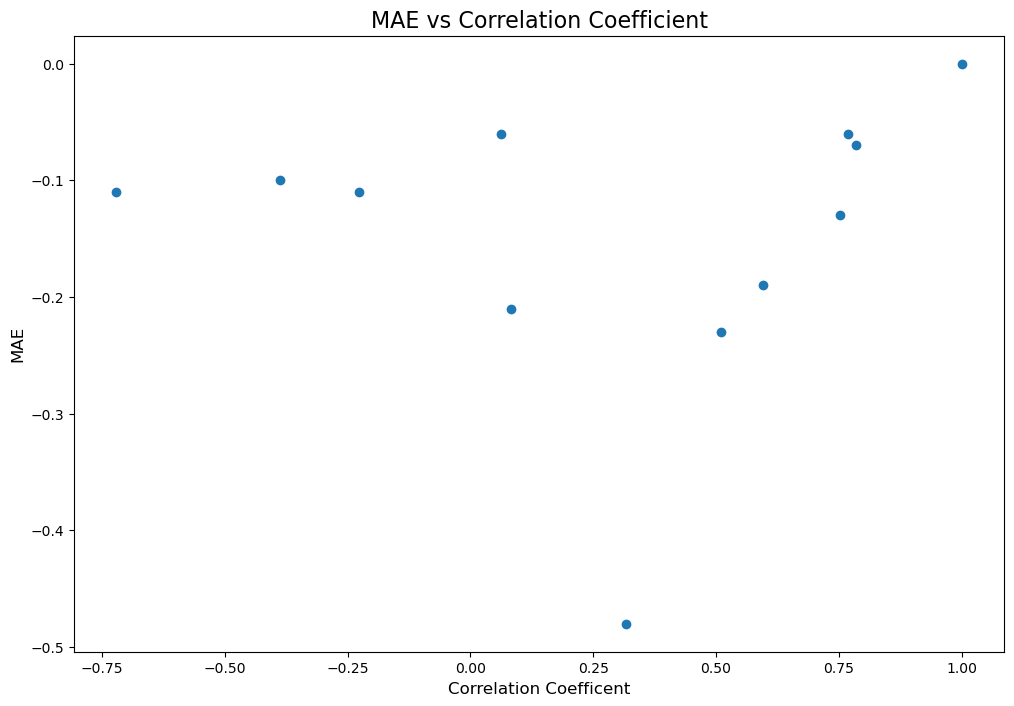

In [43]:
plt.figure(figsize=(12,8))
plt.scatter(x[:12],y[:12])
plt.title("MAE vs Correlation Coefficient", fontsize=16)
plt.xlabel("Correlation Coefficent", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.show()

In [38]:
n = len(x)
tol = 0.9
x_c = []
y_c = []
for i in range(n):
    if(x[i] >= tol and x[i] != 1):
        x_c.append(x[i])
        y_c.append(y[i])
print(len(x_c))

6


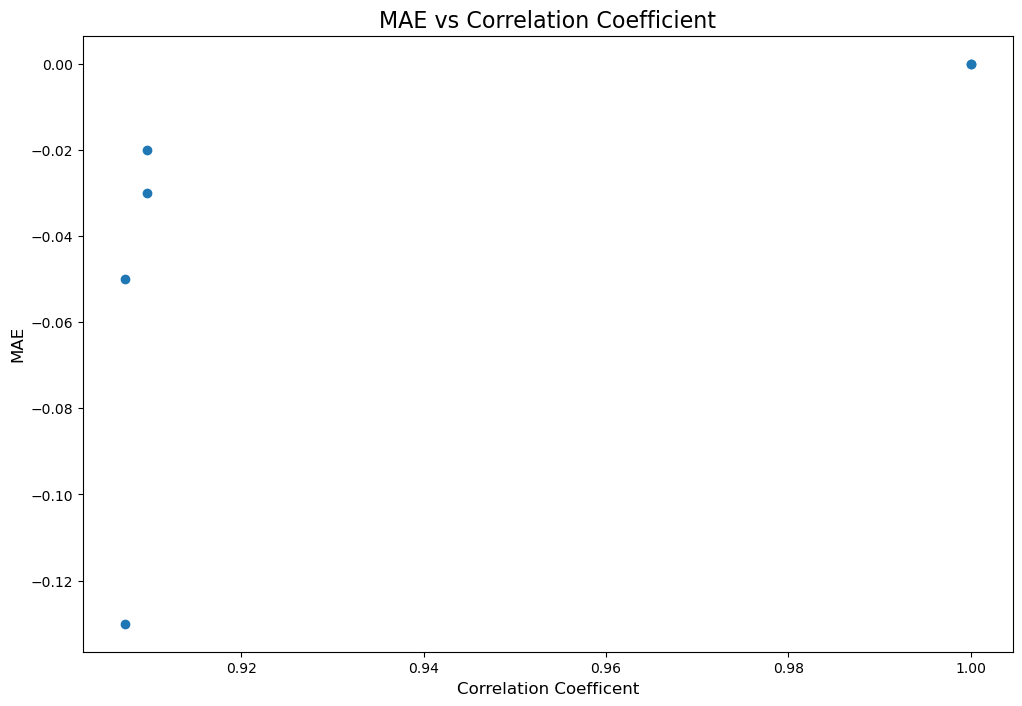

In [39]:
plt.figure(figsize=(12,8))
plt.scatter(x_c,y_c)
plt.title("MAE vs Correlation Coefficient", fontsize=16)
plt.xlabel("Correlation Coefficent", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.show()